In [1]:
from pathlib import Path
import json
import numpy as np
from PIL import Image
from tqdm import tqdm

# === 路径配置 ===
SEQ = "c1_descending_t2_v2"

STAGE_A_ROOT = Path(f"/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/{SEQ}")
STAGE_D_ROOT = Path(f"/data1_ycao/chua/projects/cdTeacher/outputs/stage_D/{SEQ}")

TRANSFORM_PATH = STAGE_A_ROOT / "transforms.json"
NS_DEPTH_ROOT  = STAGE_D_ROOT / "ns_depth" / "test"   # 你 ns-render 输出里打印的那个路径

print("TRANSFORM_PATH:", TRANSFORM_PATH)
print("NS_DEPTH_ROOT :", NS_DEPTH_ROOT)


TRANSFORM_PATH: /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/transforms.json
NS_DEPTH_ROOT : /data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_depth/test


In [2]:
# 读取 transforms.json
with open(TRANSFORM_PATH, "r") as f:
    meta = json.load(f)

W_p = int(meta["w"])
H_p = int(meta["h"])
fx  = float(meta["fl_x"])
fy  = float(meta["fl_y"])
cx  = float(meta["cx"])
cy  = float(meta["cy"])

print("Pinhole intrinsics:")
print("  W,H =", W_p, H_p)
print("  fx,fy,cx,cy =", fx, fy, cx, cy)

# 生成 pinhole 相机下的射线方向 (H,W,3)
u = np.arange(W_p, dtype=np.float32)
v = np.arange(H_p, dtype=np.float32)
uu, vv = np.meshgrid(u, v)  # (H,W)

x = (uu - cx) / fx
y = (vv - cy) / fy
z = np.ones_like(x, dtype=np.float32)

dirs = np.stack([x, y, z], axis=-1)  # (H,W,3)
norm = np.linalg.norm(dirs, axis=-1, keepdims=True)
dirs_cam_pinhole = dirs / np.clip(norm, 1e-8, None)
print("dirs_cam_pinhole shape:", dirs_cam_pinhole.shape)

# 提取 cam2world pose，注意顺序要和 Nerfstudio 的 frame index 对齐
poses_c2w_list = []
for f_info in meta["frames"]:
    T = np.array(f_info["transform_matrix"], dtype=np.float32)
    poses_c2w_list.append(T)

poses_c2w = np.stack(poses_c2w_list, axis=0)  # (N,4,4)
num_frames = poses_c2w.shape[0]
print("poses_c2w:", poses_c2w.shape)


Pinhole intrinsics:
  W,H = 960 720
  fx,fy,cx,cy = 480.00000000000006 480.00000000000006 480.0 360.0
dirs_cam_pinhole shape: (720, 960, 3)
poses_c2w: (617, 4, 4)


In [3]:
import os

cand_depth = NS_DEPTH_ROOT / "depth"

if cand_depth.is_dir():
    depth_dir = cand_depth
    print("Using depth directory:", depth_dir)
else:
    # 兜底：递归找所有 png，后面直接用
    depth_dir = None
    png_files = list(NS_DEPTH_ROOT.rglob("*.png"))
    print("No raw-depth/depth dir found, found png files:", len(png_files))
    if len(png_files) == 0:
        raise FileNotFoundError("No PNG depth outputs found under NS_DEPTH_ROOT")


Using depth directory: /data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_depth/test/depth


In [ ]:
def load_nerf_depth(frame_id: int):
    """
    读取 NeRF 渲染出的 depth colormap 图。
    返回: depth_m: (H,W) float32，相对/绝对深度（单位：场景单位，不一定是m，但可以 up-to-scale）。
    """
    if depth_dir is not None:
        d_path = depth_dir / f"{frame_id:04d}.png"
    else:
        # 兜底模式：在 png_files 里找名字是 frame_id 的
        candidates = [p for p in png_files if p.stem == f"{frame_id:04d}"]
        if len(candidates) == 0:
            return None
        d_path = candidates[0]

    if not d_path.exists():
        # 对 test split 来说，有些 fid 可能没有，对应 skip
        return None

    depth_img = np.array(Image.open(d_path))

    # 情况 1：16-bit 灰度，典型 raw-depth 存法
    if depth_img.dtype == np.uint16 and depth_img.ndim == 2:
        depth_norm = depth_img.astype(np.float32) / 65535.0
        # 这里先当成 0~1 的相对深度，后续几何比较可以 up-to-scale
        depth_m = depth_norm

    # 情况 2：8-bit 灰度，按 0~1 归一
    elif depth_img.dtype == np.uint8 and depth_img.ndim == 2:
        depth_m = depth_img.astype(np.float32)
        depth_m /= (depth_m.max() + 1e-8)

    # 情况 3：3 通道彩色（colormap），取灰度/单通道当相对深度
    elif depth_img.ndim == 3:
        # 简单取 luminance 或某一通道
        depth_gray = depth_img.mean(axis=-1).astype(np.float32)
        depth_m = depth_gray / (depth_gray.max() + 1e-8)

    else:
        raise ValueError(f"Unsupported depth image shape/dtype: {depth_img.shape}, {depth_img.dtype}")

    if depth_m.shape != (H_p, W_p):
        raise ValueError(f"Depth shape {depth_m.shape} != ({H_p},{W_p})")

    return depth_m


In [5]:
def nerf_points_world_from_depth(frame_id: int, max_points: int = None):
    """
    从 NeRF depth 恢复一帧的世界系点云 (N,3)，CPU / NumPy 实现。
    """
    depth_m = load_nerf_depth(frame_id)
    if depth_m is None:
        return None

    # 有效像素：深度 > 0
    valid = depth_m > 0
    if not np.any(valid):
        return None

    d_valid = depth_m[valid]                # (Nv,)
    dirs_valid = dirs_cam_pinhole[valid]    # (Nv,3)

    pts_cam = dirs_valid * d_valid[:, None]  # (Nv,3)

    T = poses_c2w[frame_id]   # (4,4)
    R = T[:3, :3]
    t = T[:3, 3]

    pts_world = pts_cam @ R.T + t[None, :]   # (Nv,3)

    # 控制每帧点数
    if max_points is not None and pts_world.shape[0] > max_points:
        idx = np.random.choice(pts_world.shape[0], max_points, replace=False)
        pts_world = pts_world[idx]

    return pts_world.astype(np.float32)


In [6]:
all_nerf_pts = []

# 遍历所有有 depth 的 frame，根据文件名推断 fid
if depth_dir is not None:
    depth_files = sorted(depth_dir.glob("*.png"))
else:
    depth_files = sorted(png_files)

print("Found depth frames:", len(depth_files))

for p in tqdm(depth_files, desc="Collect NeRF points"):
    try:
        fid = int(p.stem)
    except ValueError:
        # 文件名不是纯 0000 的就跳过
        continue
    pts_w = nerf_points_world_from_depth(fid, max_points=10000)
    if pts_w is None:
        continue
    all_nerf_pts.append(pts_w)

if len(all_nerf_pts) == 0:
    print("No NeRF points collected, check depth outputs.")
else:
    nerf_pts = np.concatenate(all_nerf_pts, axis=0)
    print("NeRF pointcloud size:", nerf_pts.shape)


Found depth frames: 61


Collect NeRF points: 100%|██████████| 61/61 [00:10<00:00,  5.60it/s]

NeRF pointcloud size: (610000, 3)


In [7]:
import open3d as o3d

gt_ply_path = STAGE_A_ROOT / "gt_pointcloud_partial.ply"
gt_pcd = o3d.io.read_point_cloud(str(gt_ply_path))
gt_pts = np.asarray(gt_pcd.points, dtype=np.float32)
print("GT points:", gt_pts.shape)

# 适当下采样，避免KD树太大
def random_subsample(pts, max_points):
    if pts.shape[0] <= max_points:
        return pts
    idx = np.random.choice(pts.shape[0], max_points, replace=False)
    return pts[idx]

gt_pts_sub   = random_subsample(gt_pts,   300_000)
nerf_pts_sub = random_subsample(nerf_pts, 300_000)

print("GT subsampled:", gt_pts_sub.shape)
print("NeRF subsampled:", nerf_pts_sub.shape)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
GT points: (615000, 3)
GT subsampled: (300000, 3)
NeRF subsampled: (300000, 3)


In [8]:
from sklearn.neighbors import NearestNeighbors

def one_sided_dist(src, tgt):
    nn = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(tgt)
    dists, _ = nn.kneighbors(src, return_distance=True)
    return dists[:, 0]  # (N,)

# NeRF -> GT
d_nerf2gt = one_sided_dist(nerf_pts_sub, gt_pts_sub)
# GT -> NeRF
d_gt2nerf = one_sided_dist(gt_pts_sub, nerf_pts_sub)

def summarize(name, d):
    print(f"{name} stats (meters):")
    print("  mean   :", float(d.mean()))
    print("  median :", float(np.median(d)))
    print("  95%ile :", float(np.percentile(d, 95)))
    print("  max    :", float(d.max()))
    print()

summarize("NeRF → GT", d_nerf2gt)
summarize("GT → NeRF", d_gt2nerf)

chamfer_like = float(d_nerf2gt.mean() + d_gt2nerf.mean())
print("Chamfer-like distance (mean sum):", chamfer_like)


NeRF → GT stats (meters):
  mean   : 0.37473442867152246
  median : 0.2015844828977221
  95%ile : 0.8827368140362524
  max    : 0.9712893955314907

GT → NeRF stats (meters):
  mean   : 0.12335500555759427
  median : 0.1285963166362356
  95%ile : 0.1384522603085785
  max    : 0.14424989270137184

Chamfer-like distance (mean sum): 0.4980894342291167


In [13]:
import gzip
import numpy as np
import torch
from tqdm import tqdm

device = torch.device("cpu")  # 故意用 CPU，避免显存炸

# 1. 加载 Nerfstudio 的 cam2world（pinhole 对应的 transforms.json）
import json, os

OUT_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2"
with open(os.path.join(OUT_ROOT, "transforms.json"), "r") as f:
    meta = json.load(f)

W_p = meta["w"]
H_p = meta["h"]
fx  = meta["fl_x"]
fy  = meta["fl_y"]
cx  = meta["cx"]
cy  = meta["cy"]

poses_c2w = torch.tensor(
    [np.array(f["transform_matrix"], dtype=np.float32) for f in meta["frames"]],
    dtype=torch.float32,
    device=device,
)  # (N,4,4)

num_frames = poses_c2w.shape[0]

# 2. 预计算 pinhole 射线方向（和训练时一致）
u = torch.arange(W_p, device=device).view(1, -1).expand(H_p, W_p)
v = torch.arange(H_p, device=device).view(-1, 1).expand(H_p, W_p)

x = (u - cx) / fx
y = (v - cy) / fy
z = torch.ones_like(x)

dirs_cam_pinhole = torch.stack([x, y, z], dim=-1)  # (H_p,W_p,3)
dirs_cam_pinhole = dirs_cam_pinhole / torch.linalg.norm(
    dirs_cam_pinhole, dim=-1, keepdim=True
)

# 3. 一个 helper：从 raw-depth 生成 NeRF 点云（带 scale α）
RAW_DEPTH_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_raw_depth/test/raw-depth"

def nerf_points_world_from_raw_depth(frame_id: int, alpha: float = 0.1, max_points: int = 10000):
    """
    alpha: 全局尺度因子，把 NeRF depth 单位绑到物理单位（米）。
           比如 alpha=0.1 表示 raw-depth=1.0 对应 0.1 m。
    """
    fname = f"{frame_id:04d}.npy.gz"
    d_path = os.path.join(RAW_DEPTH_ROOT, fname)
    if not os.path.exists(d_path):
        return None

    # 读 raw-depth
    with gzip.open(d_path, "rb") as f:
        d = np.load(f)
    depth = torch.from_numpy(d.squeeze(-1)).to(device=device, dtype=torch.float32)  # (H_p,W_p)

    # 有效像素
    valid = torch.isfinite(depth) & (depth > 0)

    if valid.sum() == 0:
        return None

    d_valid = depth[valid] * alpha                 # (Nv,) 转成“物理距离”
    dirs_valid = dirs_cam_pinhole[valid]           # (Nv,3)

    pts_cam = dirs_valid * d_valid.unsqueeze(-1)   # (Nv,3)

    T_c2w = poses_c2w[frame_id]                    # (4,4)
    R = T_c2w[:3, :3]
    t = T_c2w[:3, 3]

    pts_w = (R @ pts_cam.T + t.view(3, 1)).T       # (Nv,3)

    if max_points is not None and pts_w.shape[0] > max_points:
        idx = torch.randperm(pts_w.shape[0])[:max_points]
        pts_w = pts_w[idx]

    return pts_w.cpu().numpy().astype(np.float32)


/tmp/ipykernel_1953637/2157112975.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  poses_c2w = torch.tensor(


In [ ]:
# %% [markdown]
# Stage D: 使用 raw-depth 重新评估 NeRF vs GT 点云几何误差
# - 上一个 cell 已经定义了：
#   - nerf_points_world_from_raw_depth(frame_id, alpha, max_points)
#   - poses_c2w, W_p, H_p, fx, fy, cx, cy 等
# - Stage A 已经生成了 GT 点云 PLY：gt_pointcloud_partial.ply

import os
import numpy as np
import open3d as o3d
from scipy.spatial import cKDTree
from glob import glob

# 1. 配置路径和参数 ---------------------------------------------------------

# 这一条是你 Stage A 用过的 OUT_ROOT，只要和上面保持一致就行
OUT_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2"

# GT 点云路径（Stage A 生成）
GT_PLY_PATH = os.path.join(OUT_ROOT, "gt_pointcloud_partial.ply")

# NeRF raw-depth 路径（你刚 ns-render 出来的）
RAW_DEPTH_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_raw_depth/test/raw-depth"

# 全局尺度因子：raw-depth=1 对应的物理距离（米）
# 先从 0.1m 开始试（因为 GT depth 的量程是 0~0.1 m）
ALPHA = 0.1

# 每侧点云最大点数
MAX_GT_POINTS   = 300_000
MAX_NERF_POINTS = 300_000
PER_FRAME_NERF  = 10_000  # 每帧从 raw-depth 采样的最大点数


# 2. 加载 GT 点云 ---------------------------------------------------------

print("Loading GT point cloud from:", GT_PLY_PATH)
pcd_gt = o3d.io.read_point_cloud(GT_PLY_PATH)
pts_gt = np.asarray(pcd_gt.points).astype(np.float32)
print("GT points total:", pts_gt.shape)

# 下采样到 MAX_GT_POINTS
if pts_gt.shape[0] > MAX_GT_POINTS:
    idx = np.random.choice(pts_gt.shape[0], MAX_GT_POINTS, replace=False)
    pts_gt_sub = pts_gt[idx]
else:
    pts_gt_sub = pts_gt

print("GT subsampled:", pts_gt_sub.shape)


# 3. 收集 NeRF 点云（遍历 raw-depth 文件） ---------------------------------

depth_files = sorted(glob(os.path.join(RAW_DEPTH_ROOT, "*.npy.gz")))
print(f"Found {len(depth_files)} raw-depth frames")

nerf_pts_list = []

for i, fpath in enumerate(depth_files):
    basename = os.path.basename(fpath)   # 例如 "0010.npy.gz"
    stem = basename.split(".")[0]        # "0010"
    fid = int(stem)

    pts = nerf_points_world_from_raw_depth(
        frame_id=fid,
        alpha=ALPHA,
        max_points=PER_FRAME_NERF,
    )
    if pts is None:
        continue

    nerf_pts_list.append(pts)
    print(f"Frame {fid:04d}: {pts.shape[0]} pts")
    if (i + 1) % 5 == 0:
        print(f"[{i+1}/{len(depth_files)} Frame {fid:04d}: {pts.shape[0]} pts]")

if len(nerf_pts_list) == 0:
    raise RuntimeError("No NeRF points collected. Check RAW_DEPTH_ROOT and nerf_points_world_from_raw_depth.")

pts_nerf = np.concatenate(nerf_pts_list, axis=0)
print("NeRF points total:", pts_nerf.shape)

# 下采样 NeRF 点云
if pts_nerf.shape[0] > MAX_NERF_POINTS:
    idx = np.random.choice(pts_nerf.shape[0], MAX_NERF_POINTS, replace=False)
    pts_nerf_sub = pts_nerf[idx]
else:
    pts_nerf_sub = pts_nerf

print("NeRF subsampled:", pts_nerf_sub.shape)


# 4. 用 cKDTree 计算双向最近邻距离（Chamfer-like） ------------------------

print("\nBuilding KD-trees...")
tree_gt   = cKDTree(pts_gt_sub)
tree_nerf = cKDTree(pts_nerf_sub)

print("Query NeRF → GT ...")
d_nerf2gt, _ = tree_gt.query(pts_nerf_sub, k=1)   # (N_nerf,)
print("Query GT → NeRF ...")
d_gt2nerf, _ = tree_nerf.query(pts_gt_sub, k=1)   # (N_gt,)

def print_stats(name, d):
    d = d.astype(np.float64)
    print(f"{name} stats (meters):")
    print(f"  mean   : {d.mean()}")
    print(f"  median : {np.median(d)}")
    print(f"  95%ile : {np.percentile(d, 95)}")
    print(f"  max    : {d.max()}")
    print()

print()
print_stats("NeRF → GT", d_nerf2gt)
print_stats("GT → NeRF", d_gt2nerf)

chamfer_like = d_nerf2gt.mean() + d_gt2nerf.mean()
print(f"Chamfer-like distance (mean sum): {chamfer_like} (meters)")
print(f"(Using ALPHA = {ALPHA} m per unit raw-depth)")


Loading GT point cloud from: /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/gt_pointcloud_partial.ply
GT points total: (615000, 3)
GT subsampled: (300000, 3)
Found 61 raw-depth frames
Frame 0010: 10000 pts
Frame 0020: 10000 pts
Frame 0030: 10000 pts
Frame 0040: 10000 pts
Frame 0050: 10000 pts
Frame 0060: 10000 pts
Frame 0070: 10000 pts
Frame 0080: 10000 pts
Frame 0090: 10000 pts
Frame 0100: 10000 pts
Frame 0111: 10000 pts
Frame 0121: 10000 pts
Frame 0131: 10000 pts
Frame 0141: 10000 pts
Frame 0151: 10000 pts
Frame 0161: 10000 pts
Frame 0171: 10000 pts
Frame 0181: 10000 pts
Frame 0191: 10000 pts
Frame 0201: 10000 pts
Frame 0212: 10000 pts
Frame 0222: 10000 pts
Frame 0232: 10000 pts
Frame 0242: 10000 pts
Frame 0252: 10000 pts
Frame 0262: 10000 pts
Frame 0272: 10000 pts
Frame 0282: 10000 pts
Frame 0292: 10000 pts
Frame 0302: 10000 pts
Frame 0313: 10000 pts
Frame 0323: 10000 pts
Frame 0333: 10000 pts
Frame 0343: 10000 pts
Frame 0353: 10000 pts
Frame 0363: 10000 pts

raw-depth: 0.000462871 0.9961228 0.009095165
gray-depth: 0.1254902 0.99607843 0.16887295


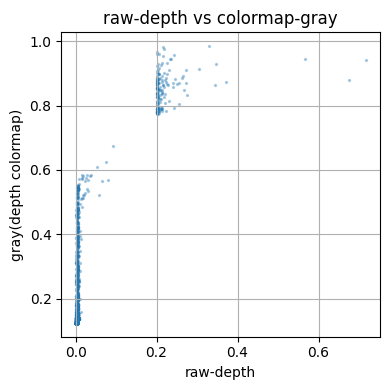

Pearson corr(raw, gray): 0.8552089622841597


In [15]:
import numpy as np
from PIL import Image
import gzip
import matplotlib.pyplot as plt

# 路径示例
raw_path = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_raw_depth/test/raw-depth/0010.npy.gz"
color_path = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_depth/test/depth/0010.png"

# 1. 读 raw-depth
with gzip.open(raw_path, "rb") as f:
    d_raw = np.load(f).squeeze(-1)   # (H,W)

# 2. 读 colormap depth，先转灰度方便比较
img = Image.open(color_path).convert("L")
d_gray = np.array(img).astype(np.float32) / 255.0   # [0,1]

print("raw-depth:", d_raw.min(), d_raw.max(), d_raw.mean())
print("gray-depth:", d_gray.min(), d_gray.max(), d_gray.mean())

# 3. 看它们是不是单调关系（散点图）
sample = np.random.choice(d_raw.size, size=5000, replace=False)
x = d_raw.reshape(-1)[sample]
y = d_gray.reshape(-1)[sample]

plt.figure(figsize=(4,4))
plt.scatter(x, y, s=2, alpha=0.3)
plt.xlabel("raw-depth")
plt.ylabel("gray(depth colormap)")
plt.title("raw-depth vs colormap-gray")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 顺手算下 Pearson 相关系数
corr = np.corrcoef(x, y)[0,1]
print("Pearson corr(raw, gray):", corr)


Loading GT point cloud from: /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/gt_pointcloud_partial.ply
GT points total: (615000, 3)
GT subsampled: (300000, 3)
Found 61 raw-depth frames in total
Using 61 frames for evaluation (stride=1)

================ α = 0.05 m =================
[5/61] Frame 0050: 10000 pts
[10/61] Frame 0100: 10000 pts
[15/61] Frame 0151: 10000 pts
[20/61] Frame 0201: 10000 pts
[25/61] Frame 0252: 10000 pts
[30/61] Frame 0302: 10000 pts
[35/61] Frame 0353: 10000 pts
[40/61] Frame 0403: 10000 pts
[45/61] Frame 0454: 10000 pts
[50/61] Frame 0504: 10000 pts
[55/61] Frame 0555: 10000 pts
[60/61] Frame 0605: 10000 pts
[61/61] Frame 0615: 10000 pts
NeRF points total: (610000, 3)
NeRF subsampled: (300000, 3)
Building KD-trees...
Query NeRF → GT ...
Query GT → NeRF ...

NeRF → GT stats (meters):
  mean   : 0.016676658796871136
  median : 0.016475711354662498
  95%ile : 0.021728428323876232
  max    : 0.4593570545649435

GT → NeRF stats (meters):
  m

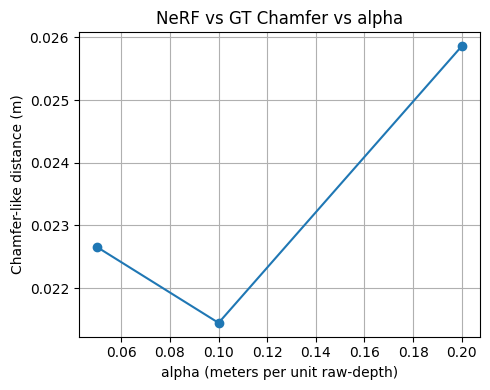

In [16]:
# %% [markdown]
# Stage D: 扫描不同 α（raw depth → 米 的尺度），比较 Chamfer 距离
# 假设：
# - nerf_points_world_from_raw_depth(frame_id, alpha, max_points) 已经定义好
# - poses_c2w, W_p, H_p, fx, fy, cx, cy 等也都在当前 notebook 里

import os
import numpy as np
import open3d as o3d
from scipy.spatial import cKDTree
from glob import glob
import matplotlib.pyplot as plt

# 1. 配置路径 -----------------------------------------------------------------

OUT_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2"
GT_PLY_PATH = os.path.join(OUT_ROOT, "gt_pointcloud_partial.ply")

RAW_DEPTH_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_D/c1_descending_t2_v2/ns_raw_depth/test/raw-depth"

# 要扫描的 α 值（raw depth = 1 → α 米）
ALPHAS = [0.05, 0.1, 0.2]

# 采样控制
MAX_GT_POINTS   = 300_000    # 每次评估对 GT 的 subsample 上限
MAX_NERF_POINTS = 300_000    # 每次评估对 NeRF 的 subsample 上限
PER_FRAME_NERF  = 10_000     # 每个 raw-depth 帧最多采样多少点

# 如果想加速，可以只用部分帧，比如每隔 3 帧取一次
FRAME_STRIDE = 1   # 1 = 用全部帧，3 = 每 3 帧取 1 帧


# 2. 加载 GT 点云（只做一次） ---------------------------------------------------

print("Loading GT point cloud from:", GT_PLY_PATH)
pcd_gt = o3d.io.read_point_cloud(GT_PLY_PATH)
pts_gt = np.asarray(pcd_gt.points).astype(np.float32)
print("GT points total:", pts_gt.shape)

if pts_gt.shape[0] > MAX_GT_POINTS:
    idx = np.random.choice(pts_gt.shape[0], MAX_GT_POINTS, replace=False)
    pts_gt_sub = pts_gt[idx]
else:
    pts_gt_sub = pts_gt

print("GT subsampled:", pts_gt_sub.shape)


# 3. 准备 raw-depth 帧列表 -----------------------------------------------------

depth_files_all = sorted(glob(os.path.join(RAW_DEPTH_ROOT, "*.npy.gz")))
print(f"Found {len(depth_files_all)} raw-depth frames in total")

depth_files = depth_files_all[::FRAME_STRIDE]
print(f"Using {len(depth_files)} frames for evaluation (stride={FRAME_STRIDE})")


# 4. 定义一个函数：给定 α，算一次 Chamfer ---------------------------------------

def evaluate_alpha(alpha: float):
    """给定 α，生成一次 NeRF 点云并计算 Chamfer-like 距离。"""
    print(f"\n================ α = {alpha} m =================")
    nerf_pts_list = []

    for i, fpath in enumerate(depth_files):
        basename = os.path.basename(fpath)   # "0010.npy.gz"
        stem = basename.split(".")[0]        # "0010"
        fid = int(stem)

        pts = nerf_points_world_from_raw_depth(
            frame_id=fid,
            alpha=alpha,
            max_points=PER_FRAME_NERF,
        )
        if pts is None:
            continue

        nerf_pts_list.append(pts)

        # 偶尔打印一下进度
        if (i + 1) % 5 == 0 or (i + 1) == len(depth_files):
            print(f"[{i+1}/{len(depth_files)}] Frame {fid:04d}: {pts.shape[0]} pts")

    if len(nerf_pts_list) == 0:
        raise RuntimeError(f"No NeRF points collected for alpha={alpha}")

    pts_nerf = np.concatenate(nerf_pts_list, axis=0).astype(np.float32)
    print("NeRF points total:", pts_nerf.shape)

    # 下采样 NeRF 点云
    if pts_nerf.shape[0] > MAX_NERF_POINTS:
        idx = np.random.choice(pts_nerf.shape[0], MAX_NERF_POINTS, replace=False)
        pts_nerf_sub = pts_nerf[idx]
    else:
        pts_nerf_sub = pts_nerf
    print("NeRF subsampled:", pts_nerf_sub.shape)

    # KD-tree
    print("Building KD-trees...")
    tree_gt   = cKDTree(pts_gt_sub)
    tree_nerf = cKDTree(pts_nerf_sub)

    print("Query NeRF → GT ...")
    d_nerf2gt, _ = tree_gt.query(pts_nerf_sub, k=1)
    print("Query GT → NeRF ...")
    d_gt2nerf, _ = tree_nerf.query(pts_gt_sub, k=1)

    d_nerf2gt = d_nerf2gt.astype(np.float64)
    d_gt2nerf = d_gt2nerf.astype(np.float64)

    def stats(d):
        return {
            "mean":   float(d.mean()),
            "median": float(np.median(d)),
            "p95":    float(np.percentile(d, 95)),
            "max":    float(d.max()),
        }

    s_n2g = stats(d_nerf2gt)
    s_g2n = stats(d_gt2nerf)
    chamfer = s_n2g["mean"] + s_g2n["mean"]

    print("\nNeRF → GT stats (meters):")
    print("  mean   :", s_n2g["mean"])
    print("  median :", s_n2g["median"])
    print("  95%ile :", s_n2g["p95"])
    print("  max    :", s_n2g["max"])

    print("\nGT → NeRF stats (meters):")
    print("  mean   :", s_g2n["mean"])
    print("  median :", s_g2n["median"])
    print("  95%ile :", s_g2n["p95"])
    print("  max    :", s_g2n["max"])

    print("\nChamfer-like distance (mean sum):", chamfer, "(meters)")
    print(f"(Using ALPHA = {alpha} m per unit raw-depth)")

    return {
        "alpha": alpha,
        "nerf2gt": s_n2g,
        "gt2nerf": s_g2n,
        "chamfer": chamfer,
    }


# 5. 对多个 α 依次评估 ---------------------------------------------------------

results = []
for alpha in ALPHAS:
    res = evaluate_alpha(alpha)
    results.append(res)

print("\n================ All α results ================")
for res in results:
    a = res["alpha"]
    print(f"α = {a}: Chamfer = {res['chamfer']:.6f} m "
          f"(NeRF→GT mean = {res['nerf2gt']['mean']:.6f}, "
          f" GT→NeRF mean = {res['gt2nerf']['mean']:.6f})")


# 6. 画一张 α vs Chamfer 的小曲线 ---------------------------------------------

alphas_plot   = [r["alpha"] for r in results]
chamfers_plot = [r["chamfer"] for r in results]

plt.figure(figsize=(5, 4))
plt.plot(alphas_plot, chamfers_plot, "-o")
plt.xlabel("alpha (meters per unit raw-depth)")
plt.ylabel("Chamfer-like distance (m)")
plt.title("NeRF vs GT Chamfer vs alpha")
plt.grid(True)
plt.tight_layout()
plt.show()
